# Plots all figures of the paper

### Table of contents

1. [Naive polling (Section 3: Initial observations)](#naive-polling)
    * [Figure 1b](#fig1b)
    * [Figure 9](#fig9)
    
2. [A-bias (Section 3)](#abias)
    * [Figure 2a](#fig2a)
    * [Figure 2b](#fig2b)
    
3. [Adjusted responses (Section 4)](#adjusted)
    * [Figure 3](#fig3)
    * [Figure 4a](#fig4a)
    * [Figure 4b](#fig4b)
    * [Figure 5](#fig5)
    * [Figure 6](#fig6)
    * [Figure 17](#fig17)
    
4. [Signal test (Section 5)](#signal)
    * [Figure 8](#fig8)
    * [Figure 14](#fig14)
    * [Table 1](#tab1)
    * [Table 2](#tab2)
 
5. [Effect of choice randomization: further experiments (Appendix C)](#randomization)
    * [Figure 10a](#fig10a)
    * [Figure 10b](#fig10b)
    * [Figure 11a](#fig11a)
    * [Figure 11b](#fig11b)
    * [Figure 12a](#fig12a)
    * [Figure 12b](#fig12b)
    
6. [Pair-wise conditionals (Appendix D)](#pairwise)
    * [Figure 13 top](#fig13top)
    * [Figure 13 bottom](#fig13bot)
    
7. [Ablation experiments (Appendix F)](#ablation)
    * [Figure 15](#fig15)
    * [Figure 16](#fig16)

In [1]:
base_dir = 'results/'
dir_individual = base_dir + 'individual/'
dir_randomization = base_dir + 'randomization/'
dir_pairwise = base_dir + 'pairwise/'
dir_ablation = base_dir + 'ablation/'
dir_signal = base_dir + 'signal_test/'
census_file = base_dir + 'pums_2019.csv'

In [2]:
import os
from tqdm import tqdm

import math
import numpy as np
import pandas as pd
from scipy.stats import chisquare

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
if not os.path.exists('plots/'):
    os.makedirs('plots/')

In [4]:
hf_models = [
    'gpt2', 'gpt2m', 'gpt2l', 'gpt2xl',
    'gptneo125m', 'gptneo1.3b', 'gptneo2.7b',
    'redpajama3b', 'redpajamachat3b', 'redpajamainstruct3b',
    'mpt', 'mpt-chat', 'mpt-instruct',
    'pythia7', 'pythia12', 'dolly12b',
    'llama7b', 'llama13b', 'llama30b',
    'alpaca7b', 'koala7b', 'koala13b', 'vicuna7b', 'vicuna13b',
    'gptneox', 'gptneoxchat',
]

openai_models = [
    'ada', 'babbage', 'curie', 'davinci',
    'text-davinci-001', 'text-davinci-002', 'text-davinci-003'
]

model_names = {
    'gpt2': 'GPT2 110M', 'gpt2m': 'GPT2 355M', 'gpt2l': 'GPT2 774M', 'gpt2xl': 'GPT2 1.5B',
    'gptneo125m': 'GPT NEO 125M', 'gptneo1.3b': 'GPT NEO 1.3B',  'gptneo2.7b': 'GPT NEO 2.7B', 
    'redpajama3b':'RedPaj. 3B', 'redpajamachat3b': 'RedPaj. Chat 3B', 'redpajamainstruct3b': 'RedPaj. Inst. 3B',
    'mpt': 'MPT 7B', 'mpt-chat': 'MPT Chat 7B', 'mpt-instruct': 'MPT Instruct 7B',
    'pythia7': 'Pythia 7B', 'pythia12': 'Pythia 12B', 'dolly12b': 'Dolly 12B',
    'llama7b': 'LLaMA 7B', 'llama13b': 'LLaMA 13B', 'llama30b': 'LLaMA 30B',
    'alpaca7b': 'Alpaca 7B', 'koala7b': 'Koala 7B', 'koala13b': 'Koala 13B', 
    'vicuna7b': 'Vicuna 7B', 'vicuna13b': 'Vicuna 13B',
    'gptneox': 'GPT NeoX 20B', 'gptneoxchat': 'NeoXT Chat 20B',
    'ada': 'GPT3 2.7B', 'babbage': 'GPT3 6.7B', 'curie': 'GPT3 13B', 'davinci': 'GPT3 175B',
    'text-davinci-001': 'text-davinci-001', 'text-davinci-002': 'text-davinci-002', 'text-davinci-003': 'text-davinci-003', 
    'uniform': 'Uniform\ndistribution', 'census': 'U.S. census'
}

model_sizes = {  # in billions of parameters
    'gpt2': 0.11, 'gpt2m': 0.355, 'gpt2l': 0.774, 'gpt2xl': 1.5, 
    'gptneo125m': 0.125, 'gptneo1.3b': 1.3, 'gptneo2.7b': 2.7,
    'redpajama3b': 3, 'redpajamachat3b': 3, 'redpajamainstruct3b': 3,
    'mpt': 6.7, 'mpt-chat': 6.7, 'mpt-instruct': 6.7,
    'pythia7': 6.9, 'pythia12': 12, 'dolly12b': 12,
    'llama7b': 7, 'llama13b': 13, 'llama30b': 30, 
    'alpaca7b': 7, 'koala7b': 7, 'koala13b': 13, 'vicuna7b': 7, 'vicuna13b': 13, 
    'gptneox': 20, 'gptneoxchat': 20, 
    'ada': 2.7, 'babbage': 6.7, 'curie':13, 'davinci': 175, 
    'text-davinci-001': 175, 'text-davinci-002': 175, 'text-davinci-003': 175, 
    'census': 190, 'uniform': 190,  # such that they are always to the right in the plots
}
for key in model_sizes.keys():  # since parameter count is given in billions
    model_sizes[key] *= 1e9

# Instruction-tuned models, with their corresponding base model
instruct = {
    'redpajamachat3b': 'redpajama3b', 'redpajamainstruct3b': 'redpajama3b',
    'mpt-chat': 'mpt', 'mpt-instruct': 'mpt',
    'dolly12b': 'pythia12',
    'alpaca7b': 'llama7b', 'koala7b': 'llama7b', 'vicuna7b': 'llama7b',
    'koala13b': 'llama13b', 'vicuna13b': 'llama13b', 
    'gptneoxchat': 'gptneox',
    'text-davinci-001': 'davinci', 'text-davinci-002':'davinci', 'text-davinci-003': 'davinci',
}

n_categories = {  # for each survey question
    'SEX': 2, 'AGER': 7, 'HISPR': 2, 'RAC1PR': 6, 'NATIVITY': 2, 'CIT': 5, 
    'SCH': 3, 'SCHLR': 5, 'LANX': 2, 'ENG': 4, 
    'HICOV': 2, 'DEAR': 2, 'DEYE': 2, 
    'MAR': 5, 'FER': 2, 'GCL': 2, 'MIL': 4, 
    'WRK': 2, 'ESR': 6, 'JWTRNS': 12, 'WKL': 3, 'WKWN': 5, 'WKHPR': 6, 'COWR': 9, 'PINCPR': 5
}

In [5]:
# various categories of models, sorted in increased size
hf_models = sorted(hf_models, key=lambda x: model_sizes[x])
all_models = sorted(hf_models + openai_models, key=lambda x: model_sizes[x])
base_models = sorted(list(set(all_models) - set(instruct.keys())), key=lambda x: model_sizes[x])
instruction_models = sorted(list(instruct.keys()), key=lambda x: model_sizes[x])
variables = list(n_categories.keys())

In [6]:
# colors used for the plots
bcolor = sb.color_palette('husl')[-2]
gcolor = sb.color_palette('husl')[2]
rcolor = sb.color_palette('husl')[0]
ocolor = sb.color_palette('muted')[1]
pcolor = [0.34901961, 0.34901961, 0.34901961, 1.]

In [7]:
# functions to compute entropy and KL divergence 
def compute_entropy(p):
    pnz = p[p!=0]
    return - np.sum(pnz * np.log2(pnz))

def compute_kl(p, q):
    nz = p != 0
    pnz = p[nz]
    qnz = q[nz]
    return np.sum(pnz * np.log2(pnz / qnz))

## Load the census data

In [8]:
def col2freq(col, n_cats, assign_nan=None, normalize=True, weight=None):
    """ 
    Inputs a pandas frame and extracts the relative frequency of each choice.
    If assign_nan is an int, then assign its rel. freq. to such choice.
    """
    p = np.zeros(n_cats)
    
    if weight is None:
        freqs = col.value_counts(dropna=assign_nan is None, normalize=normalize)
    else:
        df = pd.concat([col, weight], axis=1)
        freqs = df.groupby(col.name, dropna=assign_nan is None)[weight.name].sum()
        if normalize:
            freqs = freqs / freqs.sum()
            
    for choice, prob in freqs.items():
        if not math.isnan(choice):
            p[int(choice)-1] = prob
            
    if assign_nan is not None:
        p[assign_nan-1] += freqs[float('nan')]
    return p

In [9]:
# raw census data, obtained from `process_acs.py`
census_data = pd.read_csv(census_file)

In [10]:
assign_nans = {v: None for v in variables}
assign_nans['FER'] = 2  # assign "less than 15 years/greater than 50 years/male" to "did not give birth in last 12 months"

In [11]:
# obtain the census responses from the raw data
census_responses = {var: col2freq(census_data[var], n_categories[var], 
                                  assign_nan=assign_nans[var], weight=census_data['PWGTP'])
                    for var in variables}

In [12]:
# compute the entropy of the uniform distribution and of the census responses
uniform_responses = {var: np.ones(n_categories[var]) / n_categories[var] for var in variables}
uniform_entropies = {var: compute_entropy(uniform_responses[var]) for var in variables}
census_entropies = {v: compute_entropy(census_responses[v]) for v in variables}
census_norm_entropies = {v: census_entropies[v] / uniform_entropies[v] for v in variables}

# Naive polling <a name="naive-polling"></a>

In [13]:
def openai_upper_bound(logp, psum, minlogp):
    """ Since the OpenAI API only gives top-k logits, fill the missing entries with an upper bound """
    not_seen = logp == -np.inf
    n_not_seen = not_seen.sum()
    p = np.exp(logp)
    if n_not_seen > 0:
        pleft = (1. - psum) / n_not_seen
        pmin = min(pleft, np.exp(minlogp))
        p[not_seen] = pmin
    return p / p.sum()

def process_naive(dataset, isopenai=False):
    """
    Inputs: pd.DataFrame output by naively filling the form
    Returns: dictionary, (survey question: response distribution)
    """
    distributions = {}
    for _, row in dataset.iterrows():
        var = row['var']
        assert var in variables, f"{var} is not among the variables"
        p = np.array([row[str(i+1)] for i in range(n_categories[var])])
        if isopenai:
            p = openai_upper_bound(p, row['sp'], row['mlogp'])
        distributions[var] = p / p.sum()
    return distributions

In [14]:
# load the naive responses
naive_responses = {var: {} for var in variables}
for model in tqdm(base_models):
    results = pd.read_csv(dir_individual + model + '_naive.csv')
    responses = process_naive(results, isopenai=model in openai_models)
    for var, response in responses.items():
        naive_responses[var][model] = response

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 714.05it/s]


In [15]:
# compute the normalized entropy of the naive responses
naive_entropies = {v: {m: compute_entropy(naive_responses[v][m]) 
                       for m in base_models} for v in variables}
naive_norm_entropies = {v: {m: naive_entropies[v][m] / uniform_entropies[v] 
                            for m in base_models} for v in variables}

### Figure 1b <a name="fig1b"></a>

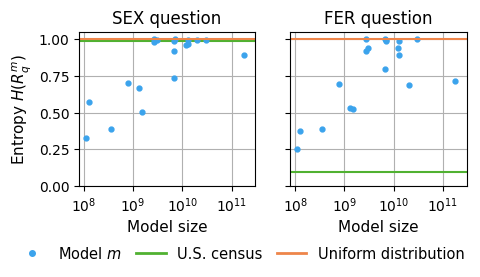

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2), sharey=True)

u = census_norm_entropies['SEX']
ax[0].plot([1e7, 1e12], [u-0.015, u-0.015], c=gcolor)  # -0.015 to avoid overlap with uniform
u = census_norm_entropies['FER']
ax[1].plot([1e7, 1e12], [u, u], c=gcolor)

msize = 7

plot_vars = ['SEX', 'FER']
sizes = [model_sizes[m] for m in base_models]
for i in range(2):
    entropies = [naive_norm_entropies[plot_vars[i]][m] for m in base_models]
    ax[i].plot(sizes, entropies, '.', c=bcolor, markersize=msize)
    ax[i].plot([1e7, 1e12], [1, 1], c=ocolor)  # uniform line
    ax[i].set_xscale('log')
    ax[i].set_ylim([0, 1.05])
    ax[i].set_xlim([8e7, 3e11])
    ax[i].set_xlabel('Model size', fontsize=11)
    ax[i].set_xticks([1e8, 1e9, 1e10, 1e11])
    ax[i].grid()
    
ax[0].set_ylabel('Entropy $H(R_q^{m})$', fontsize=11)
ax[0].set_title('SEX question')
ax[1].set_title('FER question')

legend_elements = []
legend_elements.append(plt.Line2D([0], [0], marker='.', color=bcolor, 
                                  label='Model $m$', markersize=msize+1, 
                                  markerfacecolor=bcolor, lw=0))
legend_elements.append(plt.Line2D([0], [0], color=gcolor, 
                                  label='U.S. census', markersize=msize+1, 
                                  markerfacecolor=gcolor, lw=2))
legend_elements.append(plt.Line2D([0], [0], color=ocolor, 
                                  label='Uniform distribution', markersize=msize+1, 
                                  markerfacecolor=ocolor, lw=2))
legend_position = (-0.28, -0.3)
ax[-1].legend(handles=legend_elements, loc='upper center', 
          bbox_to_anchor=legend_position, frameon=False, ncols=3, fontsize=10.5, columnspacing=1.)

plt.savefig('plots/naive_sex_fer.pdf', bbox_inches='tight')

### Figure 9 <a name="fig9"></a>

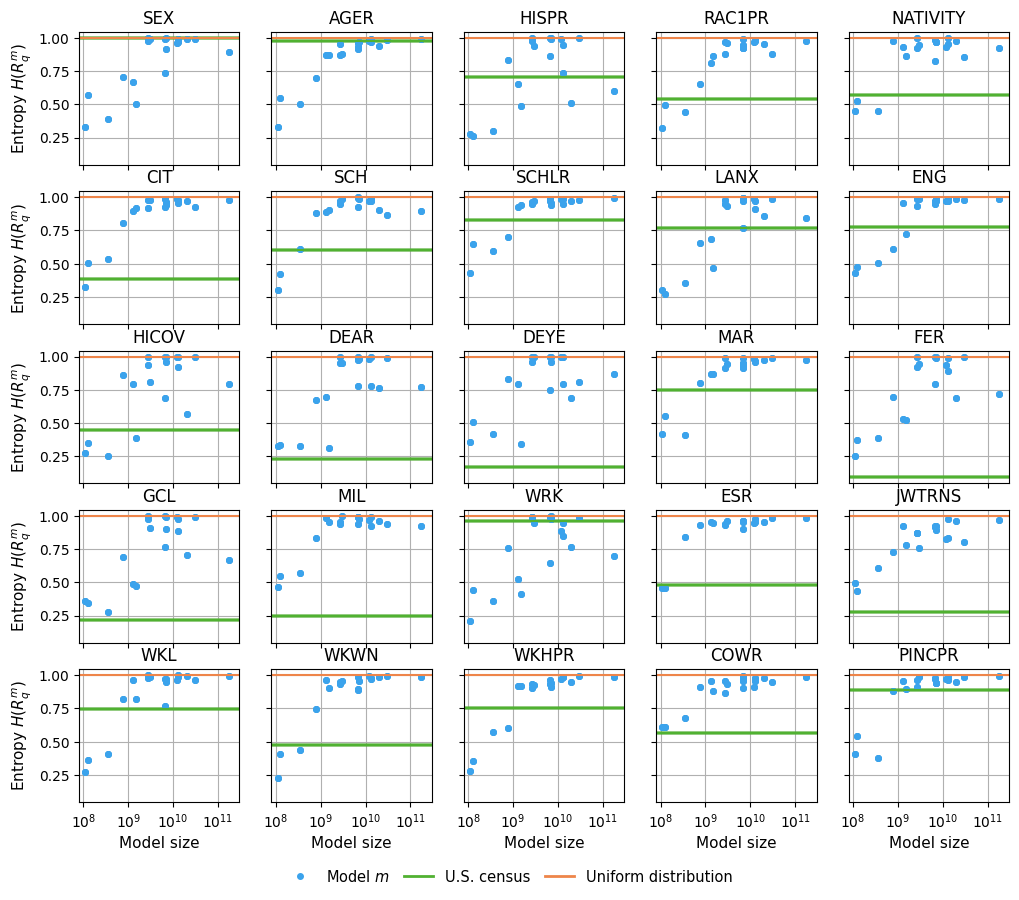

In [17]:
fig, ax = plt.subplots(5, 5, figsize=(12, 10), sharey=True, sharex=True)

msize = 7
sizes = [model_sizes[m] for m in base_models]
for i, var in enumerate(variables):
    entropies = [naive_norm_entropies[var][m] for m in base_models]
    for model in base_models:
        ax[i//5, i%5].plot(sizes, entropies, '.', c=bcolor, markersize=msize)
        cens_ent = census_norm_entropies[var]
        ax[i//5, i%5].plot([1e7, 1e12], [cens_ent, cens_ent], c=gcolor)
        ax[i//5, i%5].set_title(var)
    
ax[0, 0].set_xscale('log')
ax[0, 0].set_xlim([8e7, 3e11])
ax[0, 0].set_xticks([1e8, 1e9, 1e10, 1e11])

# x and y labels
for i in range(5):
    ax[i, 0].set_ylabel('Entropy $H(R_q^{m})$', fontsize=11)
    ax[-1, i].set_xlabel('Model size', fontsize=11)
    for j in range(5):
        ax[i, j].grid()
        ax[i, j].plot([1e7, 1e12], [1, 1], c=ocolor)

legend_elements = []
legend_elements.append(plt.Line2D([0], [0], marker='.', color=bcolor, 
                                  label='Model $m$', markersize=msize+1, 
                                  markerfacecolor=bcolor, lw=0))
legend_elements.append(plt.Line2D([0], [0], color=gcolor, 
                                  label='U.S. census', markersize=msize+1, 
                                  markerfacecolor=gcolor, lw=2))
legend_elements.append(plt.Line2D([0], [0], color=ocolor, 
                                  label='Uniform distribution', markersize=msize+1, 
                                  markerfacecolor=ocolor, lw=2))

legend_position = (0.28, -0.4)  # Coordinates (x, y) for top left position
ax[-1, 2].legend(handles=legend_elements, loc='upper center', 
          bbox_to_anchor=legend_position, frameon=False, ncols=3, fontsize=10.5, columnspacing=1.)

plt.savefig('plots/all_vars.pdf', bbox_inches='tight')

# A-bias (randomized choice ordering) <a name="abias"></a>

In [18]:
def process_adjusted(df, n_cats, isopenai=False):
    pkey = 'logp' if isopenai else 'p'
    c_columns = ['c'+str(i) for i in range(n_cats)]
    p_columns = [pkey+str(i) for i in range(n_cats)]
    
    # Get the probabilities (in the order that they were presented)
    p = df[p_columns].to_numpy()
    
    # If openai, upper bound
    if isopenai:  # since it is logps
        sumps = df['sp'].to_numpy()
        minlogps = df['mlogp'].to_numpy()
        p = np.array([openai_upper_bound(p[i], sumps[i], minlogps[i]) for i in range(p.shape[0])])
        
    choices_p = p.mean(axis=0)

    # Place the probabilities in the choice order, and average
    ids = df[c_columns].to_numpy() - 1  # since 1-indexed
    p = np.array([p[i, ids[i]] for i in range(p.shape[0])])
    p = p.mean(axis=0)
    return choices_p, p

In [19]:
# obtain the models' response distributions and choice distributions
choice_responses = {var: {} for var in variables}
adjusted_responses = {var: {} for var in variables}
for model in tqdm(all_models):
    for var in variables:
        results = pd.read_csv(dir_individual + model + f"_{var}.csv")
        choices_p, p = process_adjusted(results, n_categories[var], isopenai=model in openai_models)
        choice_responses[var][model] = choices_p
        adjusted_responses[var][model] = p

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 23.55it/s]


### Figure 2a <a name="fig2a"></a>

In [20]:
# Compute A-bias from the choice response distribution
a_bias = {m: [choice_responses[v][m][0] - (1. / n_categories[v]) for v in variables] for m in base_models}

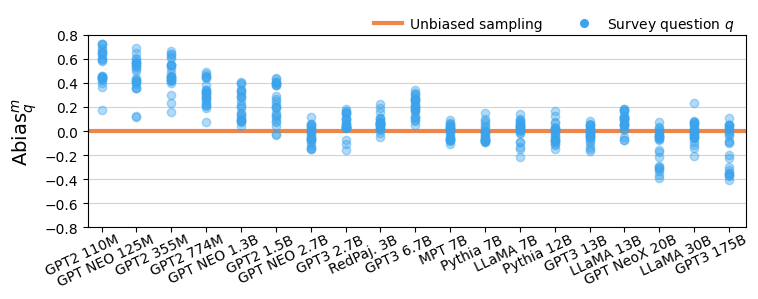

In [21]:
fig, ax = plt.subplots(figsize=(8.5, 2.5))

# plot the a-bias of each model
for i, model in enumerate(base_models):
    ys = a_bias[model]
    xs = [i for _ in ys]
    ax.plot(xs, ys, '.', c=bcolor, alpha=0.4, markersize=12)
    
# plot the line corresponding to an unbiased model
ax.plot([-0.5, len(base_models)], [0, 0], '-', zorder=1, c=ocolor, linewidth=3.0)

# legend
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], color=ocolor, 
                                  label='Unbiased sampling', markersize=11, 
                                  markerfacecolor=ocolor, lw=3))
legend_elements.append(plt.Line2D([0], [0], marker='.', color=bcolor, 
                                  label='Survey question $q$', markersize=11, 
                                  markerfacecolor=bcolor, lw=0))
legend_position = (1.0, 1.17)  # Coordinates (x, y) for top left position
ax.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=legend_position, frameon=False, ncols=3, handletextpad=.6,)

# x-axis
dx = 0.2; dy = 0.05
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
ax.set_xticks([i for i in range(len(base_models))])
labels = [model_names[m] for m in base_models]
ax.set_xticklabels(labels, rotation=25, ha='right', fontsize=10)
ax.set_xlim([-0.4, len(base_models)-0.5])

# y-axis
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.set_axisbelow(True)
ax.set_ylim([-0.8, 0.8])
ax.set_yticks([-0.8, -0.6, -0.4, -0.2, 0., 0.2, 0.4, 0.6, 0.8])
ax.set_ylabel('Abias$^m_q$', fontsize=14)
ax.tick_params(axis='y', which='both', labelsize=10)

plt.savefig('plots/a_bias.pdf', bbox_inches='tight')

**Note**: the arXiv v1 shows slightly lower A-bias of the smaller language models due to a small error in how A-bias was being computed. Trends nonetheless remain similar. The figure will be updated in the arXiv v2.

### Figure 2b <a name="fig2b"></a>

In [22]:
mean_abias_magnitude = [np.mean(np.abs(a_bias[m])) for m in base_models]
mean_entropy = [np.mean([naive_norm_entropies[v][m] for v in variables]) for m in base_models]

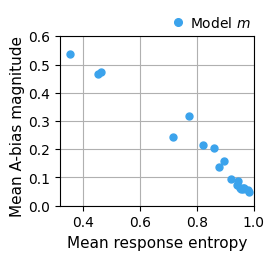

In [23]:
fig, ax = plt.subplots(figsize=(2.5, 2.2))

# abias vs entropy
ax.plot(mean_entropy, mean_abias_magnitude, '.', c=bcolor, markersize=10)

# legend
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], marker='.', color=bcolor, 
                                  label='Model $m$', markersize=11, 
                                  markerfacecolor=bcolor, lw=0))
legend_position = (1.05, 1.2)  # Coordinates (x, y) for top left position
ax.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=legend_position, frameon=False, handletextpad=-0.1, ncols=3, columnspacing=-0.7)

ax.set_ylim([0, 0.6])
ax.set_xlim([0.32, 1.])
ax.grid()

ax.set_xlabel(r'Mean response entropy', fontsize=11)
ax.set_ylabel('Mean A-bias magnitude', fontsize=11)
ax.yaxis.set_label_coords(-0.18,0.47)

plt.savefig('plots/abias-vs-entropy.pdf', bbox_inches='tight')

**Note**: the figure in the arXiv v1 slightly differs to this one due to a small error in how A-bias was being computed. The correlation between A-bias and (unadjusted) response entropy is nonetheless stark. The figure will be updated in the arXiv v2.

# Model responses after adjusting for A-bias <a name="adjusted"></a>

### Figure 3 <a name="fig3"></a>

In [24]:
# compute the normalized entropy of the adjusted responses
adjusted_entropies = {v: {m: compute_entropy(adjusted_responses[v][m]) 
                       for m in all_models} for v in variables}
adjusted_norm_entropies = {v: {m: adjusted_entropies[v][m] / uniform_entropies[v] 
                            for m in all_models} for v in variables}

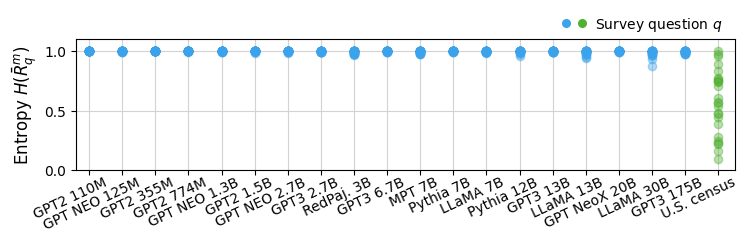

In [25]:
fig, ax = plt.subplots(figsize=(8.5, 1.7))

# plot the entropy of each model
for i, model in enumerate(base_models):
    xs = [i for _ in variables]
    ys = [adjusted_norm_entropies[v][model] for v in variables]
    ax.plot(xs, ys, '.', c=bcolor, alpha=0.4, markersize=12)

# plot the census entropy
xs = [len(base_models) for _ in variables]
ys = census_norm_entropies.values()
ax.plot(xs, ys, '.', c=gcolor, alpha=0.4, markersize=12)

# legend
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], marker='.', color=bcolor, 
                                  label='', markersize=11, 
                                  markerfacecolor=bcolor, lw=0))
legend_elements.append(plt.Line2D([0], [0], marker='.', color=gcolor, 
                                  label='Survey question $q$', markersize=11, 
                                  markerfacecolor=gcolor, lw=0))
legend_position = (1., 1.28)  # Coordinates (x, y) for top left position
ax.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=legend_position, frameon=False, handletextpad=-0.1, ncols=2, columnspacing=-0.7)

# x-ticks
dx = 0.2; dy = 0.05
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
ax.set_xticks([i for i in range(len(base_models)+1)])
labels = [model_names[m] for m in base_models + ['census']]
ax.set_xticklabels(labels, rotation=25, ha='right', fontsize=10)

ax.set_xlim([-0.4, len(base_models)+0.5])

# ax.grid('x', zorder=-10)
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.set_axisbelow(True)
ax.set_ylim([0, 1.1])
ax.set_ylabel(r'Entropy $H(\bar R^m_q)$', fontsize=12)
ax.tick_params(axis='y', which='both', labelsize=10)
plt.savefig('plots/adjusted_entropy.pdf', bbox_inches='tight')

### Figure 4a <a name="fig4a"></a>

In [26]:
instruction_delta_entropy = {m: [adjusted_norm_entropies[v][m] - adjusted_norm_entropies[v][instruct[m]]
                              for v in variables] for m in instruction_models}

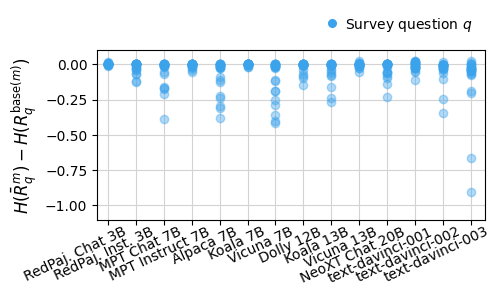

In [27]:
fig, ax = plt.subplots(figsize=(5, 2.2))

# plot the change in entropy
for i, model in enumerate(instruction_models):
    xs = [i for _ in variables]
    ys = instruction_delta_entropy[model]
    ax.plot(xs, ys, '.', c=bcolor, alpha=0.4, markersize=12)

# legend
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], marker='.', color=bcolor, 
                                  label='Survey question $q$', markersize=11, 
                                  markerfacecolor=bcolor, lw=0))
legend_position = (1., 1.28)  # Coordinates (x, y) for top left position
ax.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=legend_position, frameon=False, handletextpad=-0.1, ncols=2, columnspacing=-0.7)

# x-ticks
dx = 0.2; dy = 0.05
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
ax.set_xticks([i for i in range(len(instruction_models))])
labels = [model_names[m] for m in instruction_models]
ax.set_xticklabels(labels, rotation=25, ha='right', fontsize=10)

ax.set_xlim([-0.4, len(instruction_models)-0.5])
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.set_axisbelow(True)
ax.set_ylim([-1.1, 0.1])
ax.set_ylabel(r'$H(\bar R^m_q)-H(R_q^{\mathrm{base}(m)})$', fontsize=12)
ax.tick_params(axis='y', which='both', labelsize=10)

plt.savefig('plots/instruction_delta_entropy.pdf', bbox_inches='tight')

### Figure 4b <a name="fig4b"></a>

In [28]:
# compute the kl from every model to the census responses
adjusted_kl_census = {v: {m: compute_kl(adjusted_responses[v][m], census_responses[v])
                   for m in all_models} for v in variables}
# compute the change in kl due to instruction tunning
instruction_delta_kl = {m: [adjusted_kl_census[v][m] - adjusted_kl_census[v][instruct[m]]
                              for v in variables] for m in instruction_models}

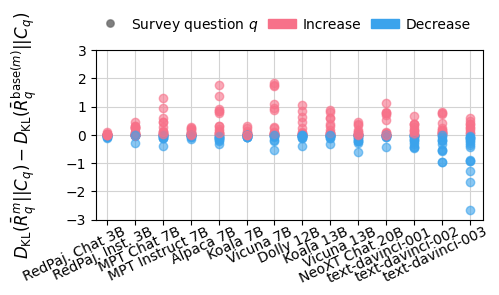

In [29]:
fig, ax = plt.subplots(figsize=(5, 2.2))

for i, model in enumerate(instruction_models):
    ys = instruction_delta_kl[model]
    for y in ys:
        color = rcolor if y > 0 else bcolor
        ax.plot(i, y, '.', c=color, alpha=0.6, markersize=12)

# legend
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], marker='.', color=pcolor, alpha=0.5,
                                  label='Survey question $q$', markersize=11, 
                                  markerfacecolor='k', lw=0))
legend_elements.append(matplotlib.patches.Patch(color=rcolor, label="Increase"))
legend_elements.append(matplotlib.patches.Patch(color=bcolor, label='Decrease'))
legend_position = (1., 1.28)  # Coordinates (x, y) for top left position
ax.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=legend_position, frameon=False, handletextpad=0.5, ncols=3, columnspacing=0.7)

# x-ticks
dx = 0.2; dy = 0.05
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
ax.set_xticks([i for i in range(len(instruction_models))])
labels = [model_names[m] for m in instruction_models]
ax.set_xticklabels(labels, rotation=25, ha='right', fontsize=10)

ax.set_ylim([-3., 3])
ax.set_xlim([-0.4, len(instruction_models)-0.5])
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.set_axisbelow(True)
ylabel = r'$ D_\mathrm{KL}(\bar R_q^m||C_q)-D_\mathrm{KL}(\bar R_q^{\mathrm{base}(m)}||C_q)$'
ylabel += '\n'
ax.set_ylabel(ylabel, fontsize=12)

plt.savefig('plots/instruction_delta_kl.pdf', bbox_inches='tight')

### Figure 5 <a name="fig5"></a>

In [30]:
# compute kl to the uniform distribution
adjusted_kl_uniform = {v: {m: compute_kl(adjusted_responses[v][m], uniform_responses[v])
                   for m in all_models} for v in variables}
# compute difference of kl_census and kl_uniform
delta_kl_census_uniform = {m: [adjusted_kl_census[v][m] - adjusted_kl_uniform[v][m]
    for v in variables] for m in all_models}

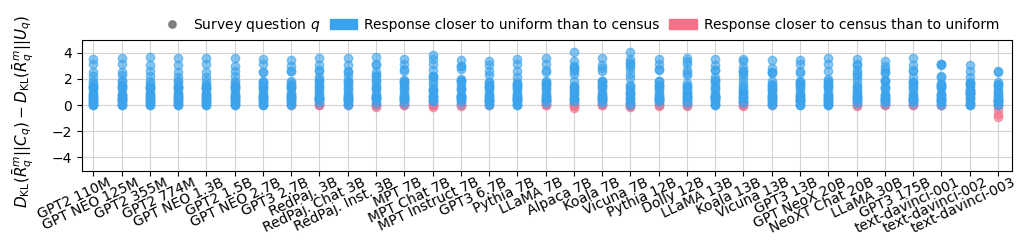

In [31]:
fig, ax = plt.subplots(figsize=(12, 1.7))

for i, model in enumerate(all_models):
    ys = delta_kl_census_uniform[model]
    for y in ys:
        color = rcolor if y < 0 else bcolor
        ax.plot(i, y, '.', c=color, alpha=0.6, markersize=12)
    
# legend 
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], marker='.', color=pcolor, alpha=0.5,
                                  label='Survey question $q$', markersize=11, 
                                  markerfacecolor='k', lw=0))
legend_elements.append(matplotlib.patches.Patch(color=bcolor, label="Response closer to uniform than to census"))
legend_elements.append(matplotlib.patches.Patch(color=rcolor, label='Response closer to census than to uniform'))
legend_position = (1., 1.28)  # Coordinates (x, y) for top left position
ax.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=legend_position, frameon=False, handletextpad=0.5, ncols=3, columnspacing=0.7)

# x-ticks
dx = 0.2; dy = 0.05
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
ax.set_xticks([i for i in range(len(all_models))])
labels = [model_names[m] for m in all_models]
ax.set_xticklabels(labels, rotation=25, ha='right', fontsize=10)

ax.set_xlim([-0.4, len(all_models)-0.5])
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.set_axisbelow(True)
ax.set_ylim([-5., 5.])
ax.set_yticks([-4.0, -2, 0, 2, 4.0])
ax.set_ylabel(r'$D_{\mathrm{KL}}(\bar R^m_q || C_q) - D_{\mathrm{KL}}(\bar R^m_q || U_q)$', fontsize=11)
ax.yaxis.set_label_coords(-0.05, 0.45)
ax.tick_params(axis='y', which='both', labelsize=10)

plt.savefig('plots/adjusted_kl_cens_unif.pdf', bbox_inches='tight')

### Figure 6 <a name="fig6"></a>

In [32]:
# calculate the response distribution of each state
states = set(census_data['ST'].unique()) - {72}  # remove Puerto Rico
responses_states = {var: {} for var in variables}
for state in tqdm(states):
    state_data = census_data[census_data['ST'] == state]
    for var in variables:
        responses_states[var][state] = col2freq(state_data[var], n_categories[var],
                                               assign_nan=assign_nans[var], weight=state_data['PWGTP'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.33it/s]


In [33]:
# calculate divergence between adjusted responses and each state
subgroup_kls = {m: {s: {} for s in states} for m in all_models}
for m in all_models:
    for s in states:
        for v in variables:
            subgroup_kls[m][s][v] = compute_kl(adjusted_responses[v][m], responses_states[v][s])

/var/folders/6b/g5148_j17tzcrm8qq__90y_w0000gn/T/ipykernel_14468/4073215627.py:10: RuntimeWarning: divide by zero encountered in divide
  return np.sum(pnz * np.log2(pnz / qnz))


In [34]:
# Do not consider ESR and JWTRNS since they contain choices with zero frequency for some of the states
# This causes KL to be infinite, but only due to finite-sampling effects
variables_used = list(set(variables) - {'ESR', 'JWTRNS'})
divergence = {m: {s: np.mean([subgroup_kls[m][s][v] for v in variables_used])
                  for s in states} for m in all_models}

In [35]:
# calculate the divergence to uniform
divergence_uniform = {m: np.mean([compute_kl(adjusted_responses[v][m], uniform_responses[v])
                                  for v in variables_used]) for m in all_models}

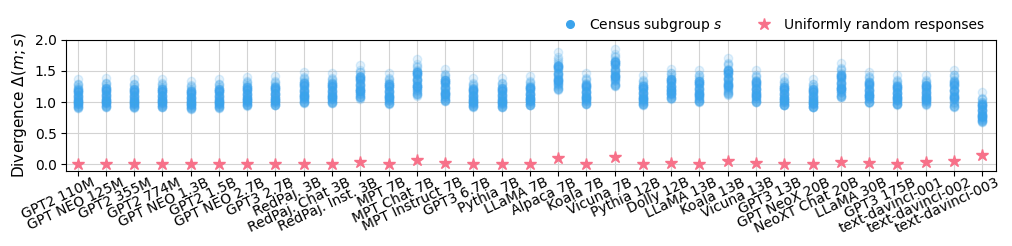

In [36]:
fig, ax = plt.subplots(figsize=(12, 1.7))

# divergence for each model
for i, model in enumerate(all_models):
    ys = list(divergence[model].values())
    xs = [i for _ in ys]
    ax.plot(xs, ys, '.', c=bcolor, alpha=0.15, markersize=12)
    # to uniform
    ax.plot(i, divergence_uniform[model], '*', c=rcolor, markersize=9)

# legend
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], marker='.', color=bcolor,
                                  label='Census subgroup $s$', markersize=11, 
                                  markerfacecolor=bcolor, lw=0))
legend_elements.append(plt.Line2D([0], [0], marker='*', color=rcolor, 
                                  label='Uniformly random responses', markersize=9, 
                                  markerfacecolor=rcolor, lw=0))
legend_position = (1., 1.28)  # Coordinates (x, y) for top left position
ax.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=legend_position, frameon=False, handletextpad=0.4, ncols=4)

# x-ticks
dx = 0.2; dy = 0.05
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
ax.set_xticks([i for i in range(len(all_models))])
labels = [model_names[m] for m in all_models]
ax.set_xticklabels(labels, rotation=25, ha='right', fontsize=10)

ax.set_xlim([-0.4, len(all_models)-0.5])
ax.set_ylim([-0.1, 2.])
ax.set_yticks([0., 0.5, 1., 1.5, 2.])
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.set_axisbelow(True)
ax.set_ylabel(r'Divergence $\Delta(m; s)$', fontsize=11)
ax.tick_params(axis='y', which='both', labelsize=10)

plt.savefig('plots/adjusted_kl_subgroups.pdf', bbox_inches='tight')

### Figure 17 <a name="fig17"></a>

In [37]:
# calculate the divergence to uniform
uniform_subgroups_kl = {v: {s: compute_kl(uniform_responses[v], responses_states[v][s])
                                  for s in states} for v in variables}

/var/folders/6b/g5148_j17tzcrm8qq__90y_w0000gn/T/ipykernel_14468/4073215627.py:10: RuntimeWarning: divide by zero encountered in divide
  return np.sum(pnz * np.log2(pnz / qnz))


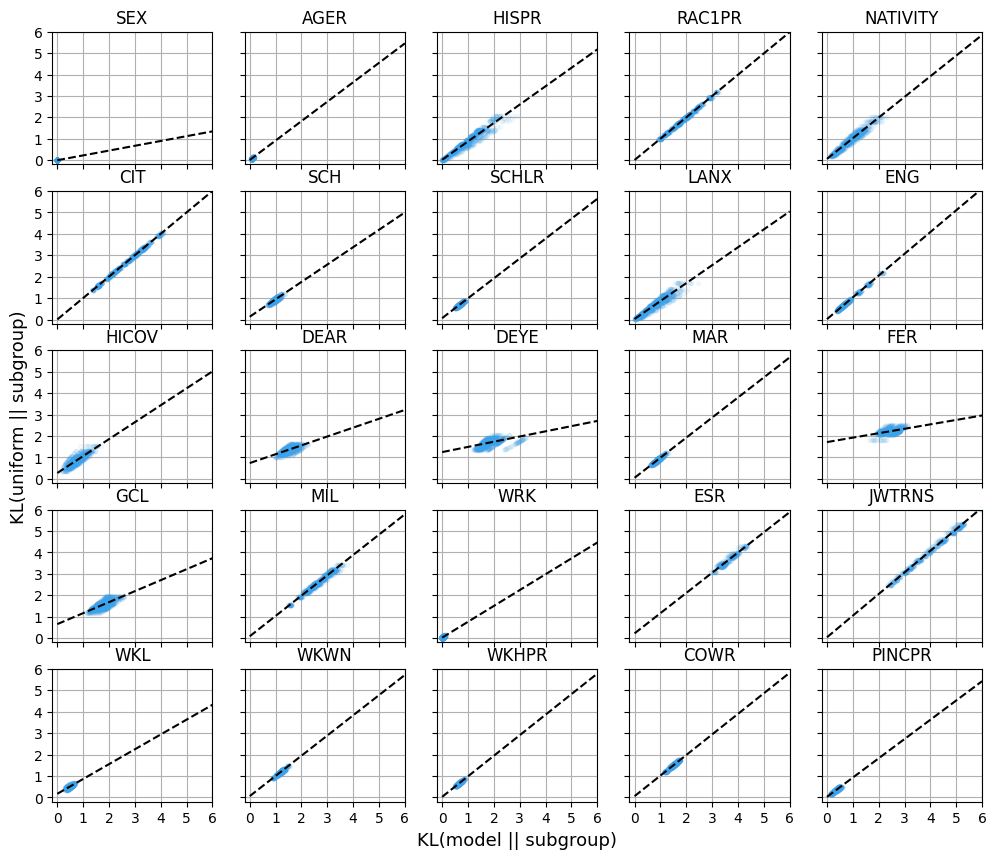

In [38]:
fig, ax = plt.subplots(5, 5, figsize=(12, 10), sharex=True, sharey=True)

for i, v in enumerate(variables):
    all_xs = []
    all_ys = []
    for m in base_models:    
        xs = np.array([subgroup_kls[m][s][v] for s in states])
        ys = np.array([uniform_subgroups_kl[v][s] for s in states])
        
        # kl might be inf due to finite sample effects, discard them
        use = ~(np.isinf(xs) | np.isinf(ys))
        xs = xs[use]
        ys = ys[use]
        
        # plot the individual data points
        c = bcolor if m in base_models else rcolor
        ax[i//5, i%5].plot(xs, ys, '.', c=c, alpha=0.05)
        
        all_xs.append(xs)
        all_ys.append(ys)

    # plot the trend line
    xs = np.concatenate(all_xs)
    ys = np.concatenate(all_ys)
    z = np.polyfit(xs, ys, 1)
    p = np.poly1d(z)
    ax[i//5, i%5].plot([0, 6],[p(0), p(6)] , "--", c='k')
        
    ax[i//5, i%5].set_title(v)
    ax[i//5, i%5].set_xlim([-0.2, 6])
    ax[i//5, i%5].set_ylim([-0.2, 6])
    ax[i//5, i%5].set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax[i//5, i%5].set_yticks([0, 1, 2, 3, 4, 5, 6])
    
for i in range(5):
    for j in range(5):
        ax[i, j].grid()
    
ax[-1, 2].set_xlabel('KL(model || subgroup)', fontsize=13)
ax[2, 0].set_ylabel('KL(uniform || subgroup)', fontsize=13)

plt.savefig('plots/adjusted_trend_kls_subgroup.pdf', bbox_inches='tight')

# Signal test <a name="signal"></a>

### Figure 8 <a name="fig8"></a>

In [39]:
census_accuracies = pd.read_csv(f"{dir_signal}summary/acs_accuracies.csv")
model_accuracies = {m: pd.read_csv(f"{dir_signal}summary/{m}_accuracies.csv") for m in hf_models}

In [40]:
tasks = list(census_accuracies['var'].unique())

def compute_signal(df, var):
    var_df = df[df['var'] == var]
    best_ml = var_df[['nb' ,'logistic', 'xgboost']].max(axis=1)
    signal = (best_ml - var_df['constant']).to_numpy()
    return np.mean(signal), np.std(signal)

In [41]:
census_signals = {v: compute_signal(census_accuracies, v) for v in tasks}
model_signals = {m: {v: compute_signal(model_accuracies[m], v) for v in tasks} for m in hf_models}

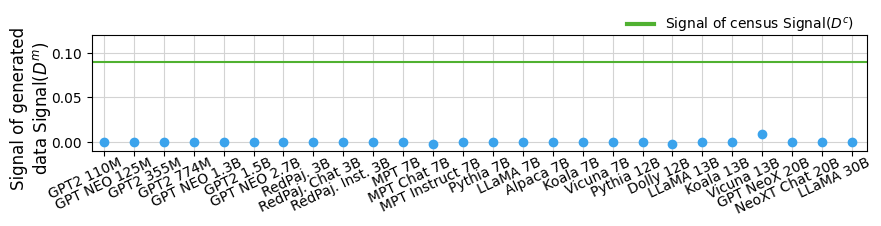

In [42]:
fig, ax = plt.subplots(figsize=(10, 1.5))

# model signal
for i, model in enumerate(hf_models):
    ax.plot(i, model_signals[model]['PINCPR'][0], '.', c=bcolor, markersize=12)

# census signal
cs = census_signals['PINCPR'][0]
ax.plot([-1, len(hf_models)], [cs, cs], color=gcolor)
        
# legend
legend_elements = [plt.Line2D([0], [0], marker='', color=gcolor, 
                                  label=r'Signal of census $\mathrm{Signal}(D^c)$', markersize=11, 
                                  markerfacecolor=gcolor, lw=3)]
legend_position = (1., 1.28)  # Coordinates (x, y) for top left position
ax.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=legend_position, frameon=False, ncols=5)

# x-ticks
dx = 0.2; dy = 0.05
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
ax.set_xticks([i for i in range(len(hf_models))])
labels = [model_names[m] for m in hf_models]
ax.set_xticklabels(labels, rotation=25, ha='right', fontsize=10)

ax.set_xlim([-0.4, len(hf_models)-0.5])
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.set_axisbelow(True)
ax.set_ylim([-0.01, 0.12])
ax.set_ylabel('Signal of generated\n' + r'data $\mathrm{Signal}\left(D^m\right)$', fontsize=12)
ax.yaxis.set_label_coords(-0.05, 0.37)
ax.tick_params(axis='y', which='both', labelsize=10)
plt.savefig('plots/signal_test.pdf', bbox_inches='tight')

### Figure 14 <a name="fig14"></a>

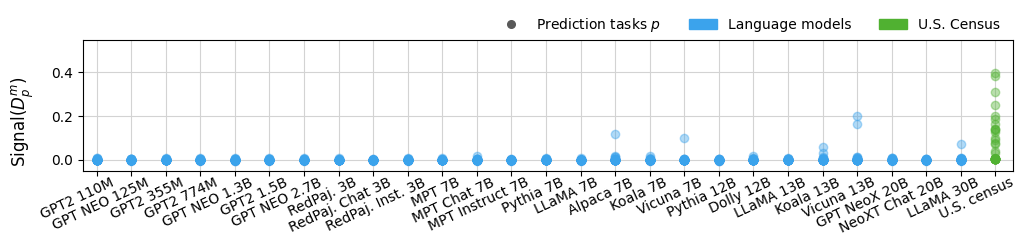

In [43]:
fig, ax = plt.subplots(figsize=(12, 1.7))

# model signals
for i, model in enumerate(hf_models):
    ys = list(model_signals[model].values())
    xs = [i for _ in ys]
    ax.plot(xs, ys, '.', c=bcolor, alpha=0.4, markersize=12)
    
# census signals
ys = list(census_signals.values())
xs = [len(hf_models) for _ in ys]
ax.plot(xs, ys, '.', c=gcolor, alpha=0.4, markersize=12)
    
# legend
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], marker='.', color=pcolor, 
                                  label=r'Prediction tasks $p$', markersize=11, 
                                  markerfacecolor=pcolor, lw=0))
legend_elements.append(matplotlib.patches.Patch(facecolor=bcolor, edgecolor=bcolor,
                         label='Language models'))
legend_elements.append(matplotlib.patches.Patch(facecolor=gcolor, edgecolor=gcolor,
                         label='U.S. Census'))
legend_position = (1., 1.28)  # Coordinates (x, y) for top left position
ax.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=legend_position, frameon=False, ncols=5)

# x-ticks
dx = 0.2; dy = 0.05
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
ax.set_xticks([i for i in range(len(hf_models)+1)])
labels = [model_names[m] for m in hf_models] + ['U.S. census']
ax.set_xticklabels(labels, rotation=25, ha='right', fontsize=10)

ax.set_xlim([-0.4, len(hf_models)+0.5])
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.set_axisbelow(True)
ax.set_ylim([-0.05, 0.55])
ax.set_ylabel(r'$\mathrm{Signal}(D_p^m)$', fontsize=12)
ax.yaxis.set_label_coords(-0.05, 0.37)
ax.tick_params(axis='y', which='both', labelsize=10)
plt.savefig('plots/signal_test_many_tasks.pdf', bbox_inches='tight')

**Note**: the figure in the arXiv v1 slightly differs to this one due to an error in the prediction task for the CIT and NATIVITY variables. Some models (Alpaca, Vicuna, Koala, Llama 30b) obtain reasonable large signal for either CIT or NATIVIY. This is to be expected since the NATIVITY question is *Where was this person born?*, and the most common answer to CIT *Is this person a citizen of the United States?* is *Yes, born in the United States*. Whereas some signal is found for these two very correlated variables, it nonetheless still evident that the datasets generated by the language models lack the statistical signals found in human populations. The figure will be updated in the arXiv v2.

In [44]:
# print the variables for which models obtain reasonably large signal
for model, var_dict in model_signals.items():
    for var, (signal, _) in var_dict.items():
        if signal > 0.05:
            print(var, model, "%.3f" % signal)

CIT alpaca7b 0.117
CIT vicuna7b 0.101
NATIVITY koala13b 0.060
NATIVITY vicuna13b 0.200
CIT vicuna13b 0.165
NATIVITY llama30b 0.074


### Table 1 <a name="tab1"></a>

In [45]:
def get_pincpr_mean_std_acc(df):
    df_pincpr = df[df['var'] == 'PINCPR'][['constant', 'nb', 'logistic', 'xgboost']]
    mean_acc = df_pincpr.mean(axis=0).to_dict()
    std_acc = df_pincpr.std(axis=0).to_dict()
    return {'mean': mean_acc, 'std': std_acc}

In [46]:
model_mean_std_acc = {m: get_pincpr_mean_std_acc(model_accuracies[m]) for m in hf_models}
census_mean_std_acc = get_pincpr_mean_std_acc(census_accuracies)

In [47]:
def get_print_row(mean_std_acc):
    return [
        mean_std_acc['mean']['constant'],
        mean_std_acc['std']['constant'],
        mean_std_acc['mean']['nb'],
        mean_std_acc['std']['nb'],
        mean_std_acc['mean']['logistic'],
        mean_std_acc['std']['logistic'],
        mean_std_acc['mean']['xgboost'],
        mean_std_acc['std']['xgboost']
    ]

for m in hf_models:
    max_std = max([model_mean_std_acc[m]['std'][c] for c in ['nb', 'logistic', 'xgboost']])
    std = model_mean_std_acc[m]['std']['constant'] + max_std
    signal = model_signals[m]['PINCPR'][0]
    signal = signal if abs(signal) > 1e-3 else 0  # prevent -0.000
    print("%s & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f \\\\" % 
          tuple([model_names[m]] + get_print_row(model_mean_std_acc[m]) + [signal, std]))

max_std = max([census_mean_std_acc['std'][c] for c in ['nb', 'logistic', 'xgboost']])
std = census_mean_std_acc['std']['constant'] + max_std
print("%s & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f \\\\" % 
          tuple(['Census'] + get_print_row(census_mean_std_acc) + [census_signals['PINCPR'][0], std]))

GPT2 110M & 0.596 $\pm$ 0.005 & 0.596 $\pm$ 0.005 & 0.596 $\pm$ 0.005 & 0.568 $\pm$ 0.004 & 0.000 $\pm$ 0.011 \\
GPT NEO 125M & 0.598 $\pm$ 0.002 & 0.598 $\pm$ 0.002 & 0.598 $\pm$ 0.002 & 0.568 $\pm$ 0.003 & 0.000 $\pm$ 0.005 \\
GPT2 355M & 0.597 $\pm$ 0.003 & 0.597 $\pm$ 0.003 & 0.597 $\pm$ 0.003 & 0.568 $\pm$ 0.003 & 0.000 $\pm$ 0.006 \\
GPT2 774M & 0.612 $\pm$ 0.005 & 0.612 $\pm$ 0.005 & 0.612 $\pm$ 0.005 & 0.587 $\pm$ 0.004 & 0.000 $\pm$ 0.011 \\
GPT NEO 1.3B & 0.593 $\pm$ 0.002 & 0.593 $\pm$ 0.002 & 0.593 $\pm$ 0.002 & 0.564 $\pm$ 0.004 & 0.000 $\pm$ 0.006 \\
GPT2 1.5B & 0.597 $\pm$ 0.003 & 0.597 $\pm$ 0.003 & 0.597 $\pm$ 0.003 & 0.567 $\pm$ 0.004 & 0.000 $\pm$ 0.007 \\
GPT NEO 2.7B & 0.598 $\pm$ 0.003 & 0.598 $\pm$ 0.003 & 0.598 $\pm$ 0.003 & 0.569 $\pm$ 0.003 & 0.000 $\pm$ 0.007 \\
RedPaj. 3B & 0.591 $\pm$ 0.003 & 0.591 $\pm$ 0.003 & 0.591 $\pm$ 0.003 & 0.560 $\pm$ 0.004 & 0.000 $\pm$ 0.007 \\
RedPaj. Chat 3B & 0.593 $\pm$ 0.004 & 0.593 $\pm$ 0.004 & 0.593 $\pm$ 0.004 & 0.563 $\

### Table 2 <a name="tab2"></a>

In [48]:
census_accuracies = pd.read_csv(f"{dir_signal}qa/acs_accuracies.csv")
model_accuracies = {m: pd.read_csv(f"{dir_signal}qa/{m}_accuracies.csv") for m in hf_models}

census_signals = {v: compute_signal(census_accuracies, v) for v in tasks}
model_signals = {m: {v: compute_signal(model_accuracies[m], v) for v in tasks} for m in hf_models}

model_mean_std_acc = {m: get_pincpr_mean_std_acc(model_accuracies[m]) for m in hf_models}
census_mean_std_acc = get_pincpr_mean_std_acc(census_accuracies)

In [49]:
def get_print_row(mean_std_acc):
    return [
        mean_std_acc['mean']['constant'],
        mean_std_acc['std']['constant'],
        mean_std_acc['mean']['nb'],
        mean_std_acc['std']['nb'],
        mean_std_acc['mean']['logistic'],
        mean_std_acc['std']['logistic'],
        mean_std_acc['mean']['xgboost'],
        mean_std_acc['std']['xgboost']
    ]

for m in hf_models:
    max_std = max([model_mean_std_acc[m]['std'][c] for c in ['nb', 'logistic', 'xgboost']])
    std = model_mean_std_acc[m]['std']['constant'] + max_std
    signal = model_signals[m]['PINCPR'][0]
    signal = signal if abs(signal) > 1e-3 else 0  # prevent -0.000
    print("%s & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f \\\\" % 
          tuple([model_names[m]] + get_print_row(model_mean_std_acc[m]) + [signal, std]))

max_std = max([census_mean_std_acc['std'][c] for c in ['nb', 'logistic', 'xgboost']])
std = census_mean_std_acc['std']['constant'] + max_std
print("%s & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f & %.3f $\pm$ %.3f \\\\" % 
          tuple(['Census'] + get_print_row(census_mean_std_acc) + [census_signals['PINCPR'][0], std]))

GPT2 110M & 0.603 $\pm$ 0.006 & 0.603 $\pm$ 0.006 & 0.603 $\pm$ 0.006 & 0.572 $\pm$ 0.003 & 0.000 $\pm$ 0.012 \\
GPT NEO 125M & 0.598 $\pm$ 0.004 & 0.598 $\pm$ 0.004 & 0.598 $\pm$ 0.004 & 0.566 $\pm$ 0.004 & 0.000 $\pm$ 0.009 \\
GPT2 355M & 0.607 $\pm$ 0.004 & 0.607 $\pm$ 0.004 & 0.607 $\pm$ 0.004 & 0.578 $\pm$ 0.003 & 0.000 $\pm$ 0.009 \\
GPT2 774M & 0.605 $\pm$ 0.004 & 0.605 $\pm$ 0.004 & 0.605 $\pm$ 0.004 & 0.577 $\pm$ 0.004 & 0.000 $\pm$ 0.007 \\
GPT NEO 1.3B & 0.596 $\pm$ 0.003 & 0.596 $\pm$ 0.003 & 0.596 $\pm$ 0.003 & 0.568 $\pm$ 0.004 & 0.000 $\pm$ 0.008 \\
GPT2 1.5B & 0.615 $\pm$ 0.004 & 0.615 $\pm$ 0.004 & 0.615 $\pm$ 0.004 & 0.590 $\pm$ 0.004 & 0.000 $\pm$ 0.008 \\
GPT NEO 2.7B & 0.602 $\pm$ 0.006 & 0.602 $\pm$ 0.006 & 0.602 $\pm$ 0.006 & 0.571 $\pm$ 0.004 & 0.000 $\pm$ 0.011 \\
RedPaj. 3B & 0.596 $\pm$ 0.004 & 0.596 $\pm$ 0.004 & 0.596 $\pm$ 0.004 & 0.563 $\pm$ 0.005 & 0.000 $\pm$ 0.009 \\
RedPaj. Chat 3B & 0.607 $\pm$ 0.004 & 0.607 $\pm$ 0.004 & 0.607 $\pm$ 0.004 & 0.578 $\

# Effect of choice randomization: further experiments <a name="randomization"></a>

In [50]:
base_hf_models = sorted(list(set(base_models) - set(openai_models)), key=lambda x: model_sizes[x])

In [51]:
def letter2freq(col, n_cats, letters, normalize=True):
    freqs = np.array([(col == l).sum() for l in letters[:n_cats]])
    if normalize:
        freqs = freqs / freqs.sum()
    return freqs

### Figure 10a <a name="fig10a"></a>

In [52]:
abc = [chr(65 + i) for i in range(26)]
order_freq = {m: {} for m in base_hf_models}
letter_freq = {m: {} for m in base_hf_models}
for model in tqdm(base_hf_models):
    df = pd.read_csv(dir_randomization+f"{model}_abc_rand_ca.csv")
    for var in variables:
        order_freq[model][var] = col2freq(df[var+'_order']+1, n_categories[var], normalize=False)
        letter_freq[model][var] = letter2freq(df[var+'_char'], n_categories[var], abc, normalize=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.72it/s]


In [53]:
p_sig = 0.05
def do_chi_test_uniform(observed_freq):
    expected_freq = np.ones_like(observed_freq) / len(observed_freq) * np.sum(observed_freq)
    chi2_stat, p_value = chisquare(observed_freq, f_exp=expected_freq)
    return p_value < p_sig  # means not uniform

In [54]:
pct_significant_order = {m: np.mean([do_chi_test_uniform(order_freq[m][v])
                                     for v in variables]) for m in base_hf_models}
pct_significant_letter = {m: np.mean([do_chi_test_uniform(letter_freq[m][v])
                                     for v in variables]) for m in base_hf_models}

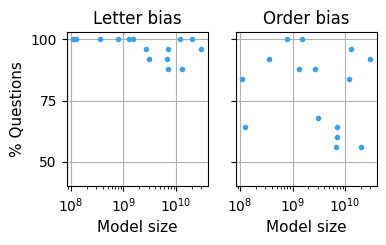

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2), sharey=True)

for model in base_hf_models:
    if model in instruct.keys():
        continue
    ax[0].plot(model_sizes[model], pct_significant_letter[model]*100, '.', c=bcolor)
    ax[1].plot(model_sizes[model], pct_significant_order[model]*100, '.', c=bcolor)

ax[0].set_ylim([40, 103])
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].grid()
ax[1].grid()
ax[0].set_yticks([50, 75, 100])
ax[0].set_xlabel('Model size', fontsize=11)
ax[1].set_xlabel('Model size', fontsize=11)
ax[0].set_ylabel('% Questions', fontsize=11)
ax[0].set_title('Letter bias')
ax[1].set_title('Order bias')
plt.savefig('plots/letter_order_bias.pdf', bbox_inches='tight')

### Figure 10b <a name="fig10b"></a>

In [56]:
first_choice_bias = {m: [(order_freq[m][v][0] / order_freq[m][v].sum()) - (1. / order_freq[m][v].shape[0])
                         for v in variables] for m in base_hf_models}

In [57]:
def bias_plot(data, ylim, ylabel, ax):
    for i, model in enumerate(base_hf_models):
        ys = data[model]
        xs = [i for _ in ys]
        ax.plot(xs, ys, '.', c=bcolor, alpha=0.4, markersize=12)
    
    # unbiased line
    ax.plot([-0.5, len(base_hf_models)], [0, 0], '-', zorder=1, c=ocolor, linewidth=3.0)

    # legend
    legend_elements = []
    legend_elements.append(plt.Line2D([0], [0], color=ocolor, 
                                      label='Unbiased sampling', markersize=11, 
                                      markerfacecolor=ocolor, lw=3))
    legend_elements.append(plt.Line2D([0], [0], marker='.', color=bcolor, 
                                      label='Survey questions', markersize=11, 
                                      markerfacecolor=bcolor, lw=0))
    legend_position = (1., 1.2)  # Coordinates (x, y) for top left position
    ax.legend(handles=legend_elements, loc='upper right', frameon=False, bbox_to_anchor=legend_position, 
              ncols=2, handletextpad=.8,)

    # x-ticks
    dx = 0.2; dy = 0.05
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
    ax.set_xticks([i for i in range(len(base_hf_models))])
    labels = [model_names[m] for m in base_hf_models]
    ax.set_xticklabels(labels, rotation=25, ha='right', fontsize=10)

    ax.set_xlim([-0.4, len(base_hf_models)-0.5])
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
    ax.set_axisbelow(True)
    ax.set_ylim([-ylim, ylim])
    ax.set_ylabel(ylabel, fontsize=12)
    ax.tick_params(axis='y', which='both', labelsize=10)

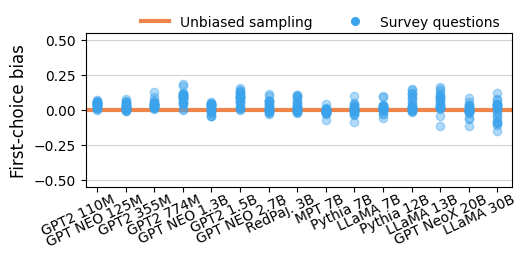

In [58]:
fig, ax = plt.subplots(figsize=(5.5, 2.))
bias_plot(first_choice_bias, 0.55, 'First-choice bias', ax)
plt.savefig('plots/randomization_first_choice_bias.pdf', bbox_inches='tight')

### Figure 11a <a name="fig11a"></a>

In [59]:
aic = [chr(65 + i) for i in range(26)]
aic[1] = 'I'
order_freq = {m: {} for m in base_hf_models}
letter_freq = {m: {} for m in base_hf_models}
for model in tqdm(base_hf_models):
    df = pd.read_csv(dir_randomization+f"{model}_aic_rand_ca.csv")
    for var in variables:
        letter_freq[model][var] = letter2freq(df[var+'_char'], n_categories[var], aic)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 48.52it/s]


In [60]:
a_bias = {m: [letter_freq[m][v][0] - (1. / len(letter_freq[m][v]))
    for v in variables] for m in base_hf_models}

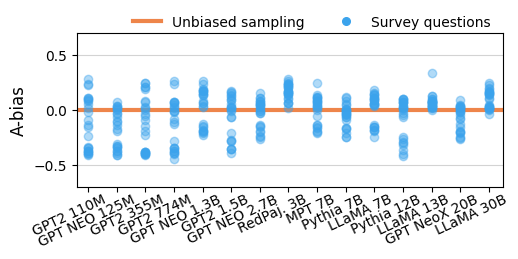

In [61]:
fig, ax = plt.subplots(figsize=(5.5, 2.))
bias_plot(a_bias, 0.7, 'A-bias', ax)
plt.savefig('plots/randomization_a_bias.pdf', bbox_inches='tight')

### Figure 11b <a name="fig11b"></a>

In [62]:
i_bias = {m: [letter_freq[m][v][1] - (1. / len(letter_freq[m][v]))
    for v in variables] for m in base_hf_models}

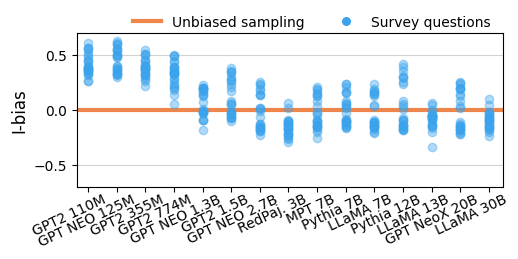

In [63]:
fig, ax = plt.subplots(figsize=(5.5, 2.))
bias_plot(i_bias, 0.7, 'I-bias', ax)
plt.savefig('plots/randomization_i_bias.pdf', bbox_inches='tight')

### Figure 12a <a name="fig12a"></a>

In [64]:
rsn = ['R', 'S', 'N', 'L', 'O', 'T', 'M', 'P', 'W', 'U', 'Y', 'V']
order_freq = {m: {} for m in base_hf_models}
letter_freq = {m: {} for m in base_hf_models}
for model in tqdm(base_hf_models):
    df = pd.read_csv(dir_randomization+f"{model}_rsn_rand_ca.csv")
    for var in variables:
        order_freq[model][var] = col2freq(df[var+'_order']+1, n_categories[var], normalize=False)
        letter_freq[model][var] = letter2freq(df[var+'_char'], n_categories[var], rsn, normalize=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.74it/s]


In [65]:
pct_significant_letter = {m: np.mean([do_chi_test_uniform(letter_freq[m][v])
                                     for v in variables]) for m in base_hf_models}

In [66]:
def plot_ordering_bias(data, title, ax):
    for model in base_hf_models:
        ax.plot(model_sizes[model], data[model]*100, '.', c='tab:blue')
    
    ax.set_ylim([40, 103])
    ax.set_xscale('log')
    ax.grid()
    ax.set_yticks([50, 60, 70, 80, 90, 100])
    ax.set_xlabel('Model size', fontsize=11)
    ax.set_ylabel('% Questions', fontsize=11)
    ax.set_title(title)

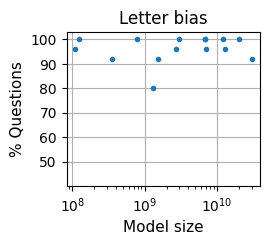

In [67]:
fig, ax = plt.subplots(figsize=(2.5, 2))
plot_ordering_bias(pct_significant_letter, 'Letter bias', ax)
plt.savefig('plots/randomization_rsn_letter_bias.pdf', bbox_inches='tight')

### Figure 12b <a name="fig12b"></a>

In [68]:
pct_significant_order = {m: np.mean([do_chi_test_uniform(order_freq[m][v])
                                     for v in variables]) for m in base_hf_models}

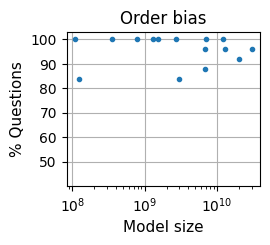

In [69]:
fig, ax = plt.subplots(figsize=(2.5, 2))
plot_ordering_bias(pct_significant_order, 'Order bias', ax)
plt.savefig('plots/randomization_rsn_order_bias.pdf', bbox_inches='tight')

# Pairwise conditionals <a name="pairwise"></a>

In [70]:
conditional_models = [
 'mpt', 'mpt-chat', 'mpt-instruct', 'pythia7', 
 'llama7b', 'alpaca7b', 'koala7b', 'vicuna7b',
 'pythia12', 'dolly12b', 'llama13b', 'koala13b', 'vicuna13b', 
 'gptneox', 'gptneoxchat', 'llama30b',
 'davinci', 'text-davinci-001', 'text-davinci-002', 'text-davinci-003'
]

In [71]:
def load_conditionals(df, n_cats1, n_cats2, isopenai=False):
    ps = {}
    for code in range(n_cats1):
        relevant = df['context_code'] == code
        if relevant.sum() > 0:
            df_rel = df[relevant]
            _, p = process_adjusted(df_rel, n_cats2, isopenai)
            p = p / p.sum()
            ps[code] = p
    return ps

In [72]:
# load the conditionals from the experiment results
model_contionals = {model: {} for model in conditional_models}
for model in tqdm(conditional_models):
    for i, var1 in enumerate(variables[:-1]):
        var2 = variables[i+1]

        # conditionals not defined for these variables
        if var1 in ['LANX', 'WKL']:
                continue
    
        results = pd.read_csv(dir_pairwise + model + f"_{var1}-{var2}.csv")
        model_contionals[model][var1] = load_conditionals(results, n_categories[var1], 
                                                          n_categories[var2], isopenai=model in openai_models)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.98it/s]


In [73]:
# load the conditionals from the census
census_conditionals = {}
for i, var1 in enumerate(variables[:-1]):
        # conditionals not defined for these variables
        if var1 in ['LANX', 'WKL']:
                continue
                
        var2 = variables[i+1]
        census_conditionals[var1] = {}
        
        for code in range(n_categories[var1]):
            relevant = census_data[var1] == code + 1
            if relevant.sum() > 0:
                census_conditionals[var1][code] = col2freq(census_data[relevant][var2], n_categories[var2])

### Figure 13 top <a name="fig13top"></a>

In [74]:
def compute_total_var(p, q):
    scaling =  (1 - 1/p.size)
    return np.sum(np.abs(p-q)) / scaling * 0.5

def maximum_pairwise_total_var(ps):
    n = len(ps)
    max_tv = -np.inf
    for i in range(n):
        for j in range(i+1, n):
            tv = compute_total_var(ps[i], ps[j])
            max_tv = max(max_tv, tv)
    return max_tv

In [75]:
max_pairwise_tvd = {m: [maximum_pairwise_total_var(list(ps.values())) 
                        for ps in model_contionals[m].values()] for m in conditional_models}
max_pairwise_tvd_census = [maximum_pairwise_total_var(list(ps.values())) 
                           for ps in census_conditionals.values()]

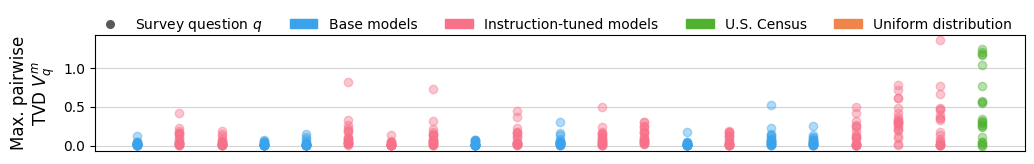

In [76]:
fig, ax = plt.subplots(figsize=(12, 1.5))

# plot the models
for i, model in enumerate(conditional_models):
    ys = max_pairwise_tvd[model]
    xs = [i for _ in ys]
    color = rcolor if model in instruct.keys() else bcolor
    ax.plot(xs, ys, '.', c=color, alpha=0.4, markersize=12)

# plot from the actual census
ys = max_pairwise_tvd_census
xs = [len(conditional_models) for _ in ys]
ax.plot(xs, ys, '.', c=gcolor, alpha=0.4, markersize=12)

# legend
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], marker='.', color=pcolor, 
                                  label='Survey question $q$', markersize=11, 
                                  markerfacecolor=pcolor, lw=0))
legend_elements.append(matplotlib.patches.Patch(facecolor=bcolor, edgecolor=bcolor,
                         label='Base models'))
legend_elements.append(matplotlib.patches.Patch(facecolor=rcolor, edgecolor=rcolor,
                         label='Instruction-tuned models'))
legend_elements.append(matplotlib.patches.Patch(facecolor=gcolor, edgecolor=gcolor,
                         label='U.S. Census'))
legend_elements.append(matplotlib.patches.Patch(facecolor=ocolor, edgecolor=ocolor,
                         label='Uniform distribution'))
legend_position = (1., 1.28)  # Coordinates (x, y) for top left position
ax.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=legend_position, frameon=False,  ncols=5)

# x-ticks
dx = 0.2; dy = 0.05
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
ax.axes.get_xaxis().set_ticks([])

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.set_axisbelow(True)
ax.set_ylabel('Max. pairwise\n' + r'TVD $V_q^m$', fontsize=12)
ax.tick_params(axis='y', which='both', labelsize=10)
plt.savefig('plots/pairwise_max_tvd.pdf', bbox_inches='tight')

### Figure 13 bottom <a name="fig13bot"></a>

In [77]:
pairwise_kl_census = {m: [] for m in conditional_models}
for model, var_ps in model_contionals.items():
    for var, code_ps in var_ps.items():
        for code, ps in code_ps.items():
            kl = compute_kl(ps, census_conditionals[var][code])
            if kl < np.inf:
                pairwise_kl_census[model].append(kl)

/var/folders/6b/g5148_j17tzcrm8qq__90y_w0000gn/T/ipykernel_14468/4073215627.py:10: RuntimeWarning: divide by zero encountered in divide
  return np.sum(pnz * np.log2(pnz / qnz))


In [78]:
pairwise_kl_uniform = []
for ps in census_conditionals.values():
    for p in ps.values():
        kl = compute_kl(np.ones_like(p) / p.size, p)
        if kl < np.inf:
            pairwise_kl_uniform.append(kl)

/var/folders/6b/g5148_j17tzcrm8qq__90y_w0000gn/T/ipykernel_14468/4073215627.py:10: RuntimeWarning: divide by zero encountered in divide
  return np.sum(pnz * np.log2(pnz / qnz))


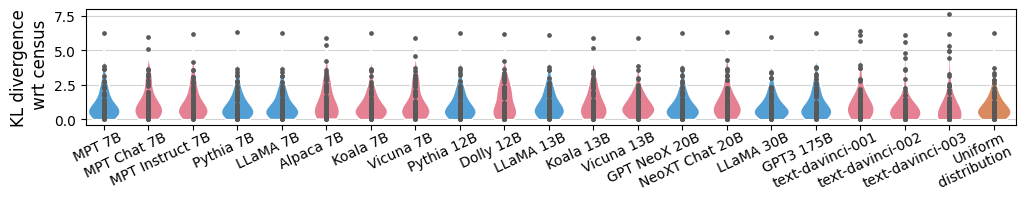

In [79]:
fig, ax = plt.subplots(figsize=(12, 1.5))

values = [pairwise_kl_census[m] for m in conditional_models] + [pairwise_kl_uniform]
palette = [rcolor if m in instruct.keys() else bcolor for m in conditional_models] + [ocolor]

bp = sb.violinplot(values, showfliers=True, ax=ax, palette=palette, cut=0, inner='point', 
                   linewidth=1.2, bw=0.5)
for i in range(0, len(bp.collections), 2):
    bp.collections[i].set_edgecolor('w')

ax.set_xticks([i for i in range(len(values))])
labels = [model_names[m] for m in conditional_models] + ["Uniform\n distribution"]
ax.set_xticklabels(labels, rotation=25, fontsize=10, ha='right')

b1 = bp.collections[0].get_facecolors()

dx = 0.2; dy = 0.05
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

points_color = bp.collections[1].get_edgecolor()
fbcolor = bp.collections[1].get_facecolor()
focolor = bp.collections[-2].get_edgecolor()

legend_elements = []
legend_elements.append(plt.Line2D([0], [0], marker='.', color='w', 
                                  label='Individual survey questions', markersize=12, markerfacecolor=points_color, lw=0))
ax.set_xlim([-0.4, len(values)-0.5])

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
ax.set_axisbelow(True)
ax.set_ylabel('KL divergence\n wrt census', fontsize=12)
ax.tick_params(axis='y', which='both', labelsize=10)
plt.savefig('plots/pairwise_kl.pdf', bbox_inches='tight')

# Ablation experiments <a name="ablation"></a>

In [80]:
ablation_models = [
 'gptneo125m', 'gpt2m', 'gpt2l', 
 'gptneo1.3b', 'gpt2xl', 'gptneo2.7b',
 'mpt', 'mpt-chat', 'mpt-instruct', 'pythia7',
 'llama7b', 'alpaca7b', 'koala7b', 'vicuna7b',
 'pythia12', 'dolly12b', 
 'llama13b', 'koala13b', 'vicuna13b', 
 'gptneox', 'gptneoxchat',
 'llama30b'
]

In [81]:
ablations = ['c0', 'c1', 'c2', 'sp']
adjusted_responses = [{var: {} for var in variables} for _ in ablations]
for i, ablation in enumerate(ablations):
    for model in tqdm(ablation_models):
        for var in variables:
            results = pd.read_csv(dir_ablation + model + f"_{ablation}_{var}.csv")
            _, p = process_adjusted(results, n_categories[var])
            adjusted_responses[i][var][model] = p

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 21.06it/s]


### Figure 15 <a name="fig15"></a>

In [82]:
# compute the normalized entropy of the adjusted responses
adjusted_entropies = [{m: {v: compute_entropy(responses[v][m]) 
                       for v in variables} for m in ablation_models} for responses in adjusted_responses]
adjusted_norm_entropies = [{m: {v: entropies[m][v] / uniform_entropies[v] 
                            for v in variables} for m in ablation_models} for entropies in adjusted_entropies]

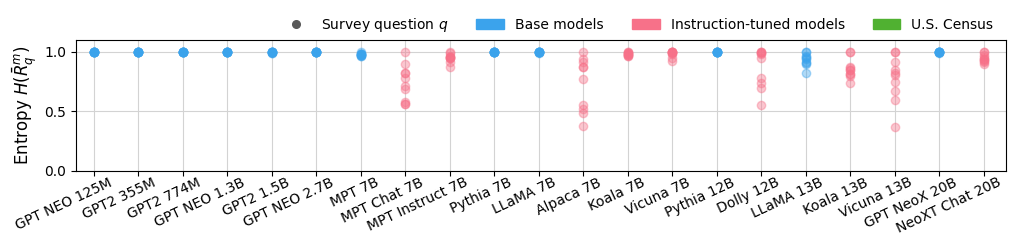

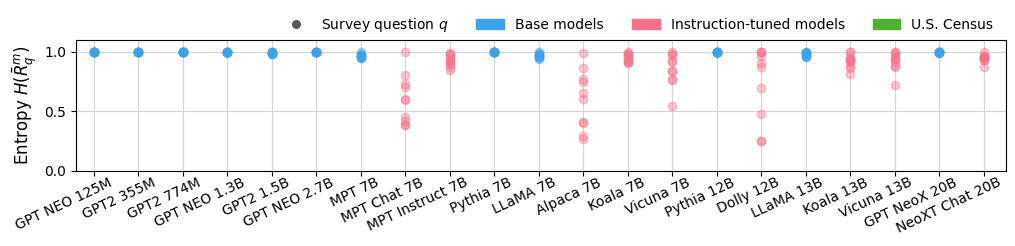

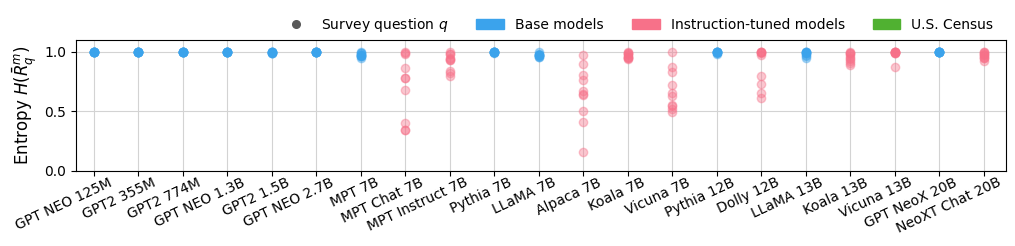

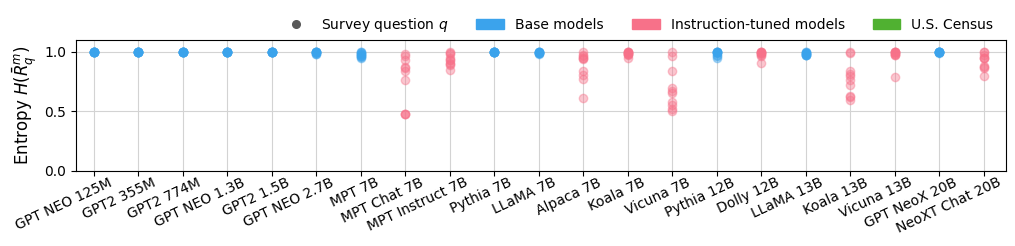

In [83]:
def make_entropy_plot(ablation_id, entropies):
    fig, ax = plt.subplots(figsize=(12, 1.7))
    
    # plot model entropies
    for i, model in enumerate(ablation_models):
        ys = list(entropies[model].values())
        xs = [i for _ in ys]
        color = rcolor if model in instruct.keys() else bcolor
        ax.plot(xs, ys, '.', c=color, alpha=0.4, markersize=12)

    # plot census entropies
    ys = list(census_entropies.values())
    xs = [len(hf_models) for _ in ys]
    ax.plot(xs, ys, '.', c=gcolor, alpha=0.4, markersize=12)
    
    # legend
    legend_elements = []
    legend_elements.append(plt.Line2D([0], [0], marker='.', color=points_color, 
                                      label='Survey question $q$', markersize=11, 
                                      markerfacecolor=points_color, lw=0))
    legend_elements.append(matplotlib.patches.Patch(facecolor=bcolor, edgecolor=bcolor,
                             label='Base models'))
    legend_elements.append(matplotlib.patches.Patch(facecolor=rcolor, edgecolor=rcolor,
                             label='Instruction-tuned models'))
    legend_elements.append(matplotlib.patches.Patch(facecolor=gcolor, edgecolor=gcolor,
                             label='U.S. Census'))
    legend_position = (1., 1.28)  # Coordinates (x, y) for top left position
    ax.legend(handles=legend_elements, loc='upper right', 
              bbox_to_anchor=legend_position, frameon=False, ncols=5)
    
    # x-ticks
    dx = 0.2; dy = 0.05
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
    ax.set_xticks([i for i in range(len(ablation_models)+1)])
    labels = [model_names[m] for m in ablation_models] + ['U.S. Census']
    ax.set_xticklabels(labels, rotation=25, ha='right', fontsize=10)

    ax.set_xlim([-0.4, len(values)-0.5])
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
    ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
    ax.set_axisbelow(True)
    ax.set_ylim([0, 1.1])
    ax.set_ylabel(r'Entropy $H(\bar R^m_q)$', fontsize=12)
    ax.tick_params(axis='y', which='both', labelsize=10)
    plt.savefig('plots/ablation_entropy_'+str(ablation_id)+'.pdf', bbox_inches='tight')
    
for i, entropies in enumerate(adjusted_entropies):
    make_entropy_plot(i, entropies)

### Figure 16 <a name="fig16"></a>

In [84]:
# compute the normalized entropy of the adjusted responses
adjusted_kl_census = [{m: {v: compute_kl(responses[v][m], census_responses[v]) 
                       for v in variables} for m in ablation_models} for responses in adjusted_responses]
kl_census_uniform = [compute_kl(np.ones_like(r)/r.size, r) for r in census_responses.values()]

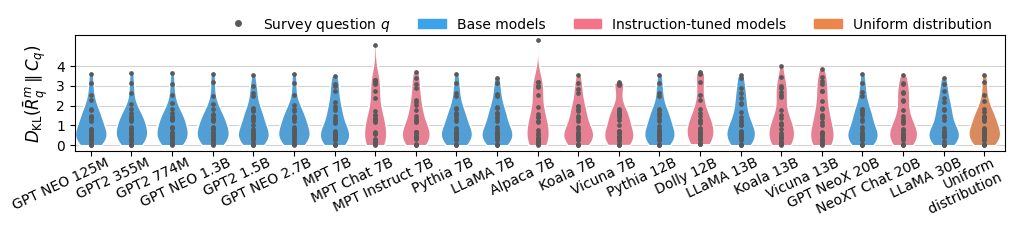

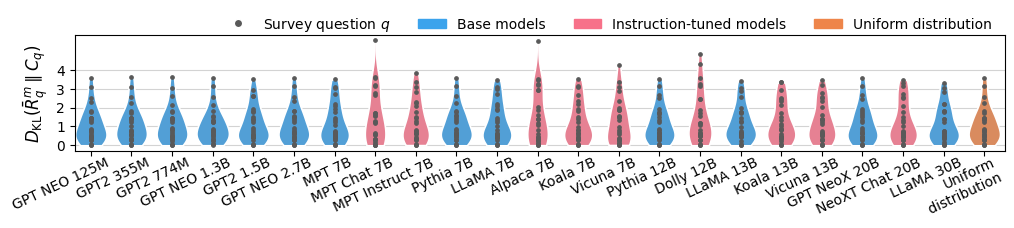

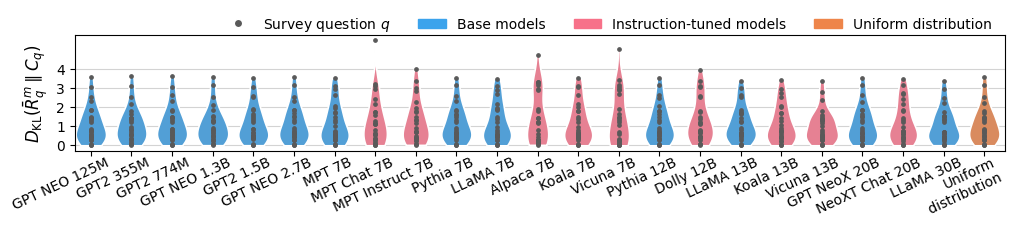

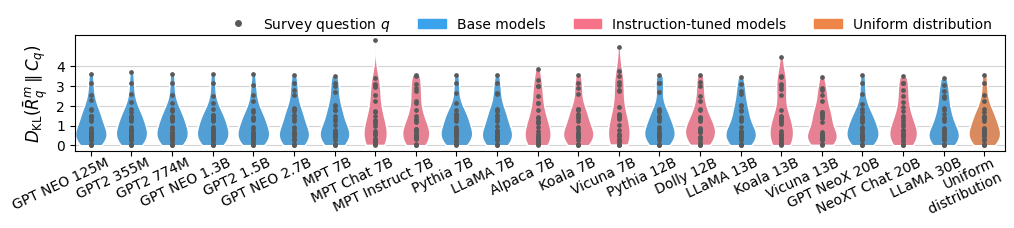

In [85]:
def make_kl_plot(ablation_id, kls):
    fig, ax = plt.subplots(figsize=(12, 1.5))
    
    
    values = [list(kls[m].values()) for m in ablation_models] + [kl_census_uniform]
    palette = [rcolor if m in instruct.keys() else bcolor for m in ablation_models] + [ocolor]
    
    bp = sb.violinplot(values, showfliers=True, ax=ax, palette=palette, cut=0, inner='point', 
                       linewidth=1.2, bw=0.5)
    for i in range(0, len(bp.collections), 2):
        bp.collections[i].set_edgecolor('w')

    ax.set_xticks([i for i in range(len(ablation_models)+1)])
    labels = [model_names[m] for m in ablation_models] + ['Uniform\n distribution']
    ax.set_xticklabels(labels, rotation=25, fontsize=10, ha='right')

    b1 = bp.collections[0].get_facecolors()
    dx = 0.2; dy = 0.05
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)

    points_color = bp.collections[1].get_edgecolor()
    fbcolor = bp.collections[1].get_facecolor()
    focolor = bp.collections[-2].get_edgecolor()
    
    # legend
    legend_elements = []
    legend_elements.append(plt.Line2D([0], [0], marker='.', color='w', 
                                      label='Survey question $q$', markersize=12, markerfacecolor=points_color, lw=0))
    legend_elements.append(matplotlib.patches.Patch(facecolor=bcolor, edgecolor=bcolor,
                             label='Base models'))
    legend_elements.append(matplotlib.patches.Patch(facecolor=rcolor, edgecolor=rcolor,
                             label='Instruction-tuned models'))
    legend_elements.append(matplotlib.patches.Patch(facecolor=ocolor, edgecolor=ocolor,
                             label='Uniform distribution'))
    legend_position = (1., 1.28)  # Coordinates (x, y) for top left position
    ax.legend(handles=legend_elements, loc='upper right', 
              bbox_to_anchor=legend_position, frameon=False, ncols=5)

    
    ax.set_xlim([-0.4, len(values)-0.5])

    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
    ax.set_axisbelow(True)
    ax.set_ylabel(r'$D_{\mathrm{KL}}(\bar R^m_q \parallel C_q)$', fontsize=12)
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.tick_params(axis='y', which='both', labelsize=10)
    plt.savefig('plots/ablation_kl_'+str(ablation_id)+'.pdf', bbox_inches='tight')
    
for i, kls in enumerate(adjusted_kl_census):
    make_kl_plot(i, kls)